# DA5401: Assignment 3
## Author: Ojas Phadake

### Roll No: CH22B007

### Date of Submission: 12-09-2025

#### Problem Statement:
This assignment aims to challenge the understanding of class imbalance,
unsupervised learning (clustering), and its application in improving the performance of a supervised classification model. It will involve use of clustering to create a more representative training
set for both the minority and majority classes through oversampling and undersampling, and
assess the impact on a Logistic Regression classifier.

The task is to utilize clustering-based oversampling and clustering-based undersampling
to create a more representative and improved training sample. You will then compare the
performance of a Logistic Regression classifier on four different training sets: the original
imbalanced data, data balanced using a naive oversampling method (SMOTE), data balanced
using a clustering-based oversampling approach (CBO), and data balanced using a
clustering-based undersampling approach (CBU).

This analysis will be done on the [Credit Card Fraud Detection Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

### Importing Libraries

In [1]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTE
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

### Part A: Data Exploration and Baseline Model

#### Load and Analyze the Dataset:

In [2]:
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud


In [3]:
df = pd.read_csv(f"{path}/creditcard.csv")
print(df.head())
print(df.shape)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

We can see that the dataset has a size of 284801 rows and 31 columns. Let us go ahead and see how the class distribution is present in the data.

### Analyze Class Distribution:

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Fraudulent transactions: 492 (0.1727%)
Non-Fraudulent transactions: 284315 (99.8273%)


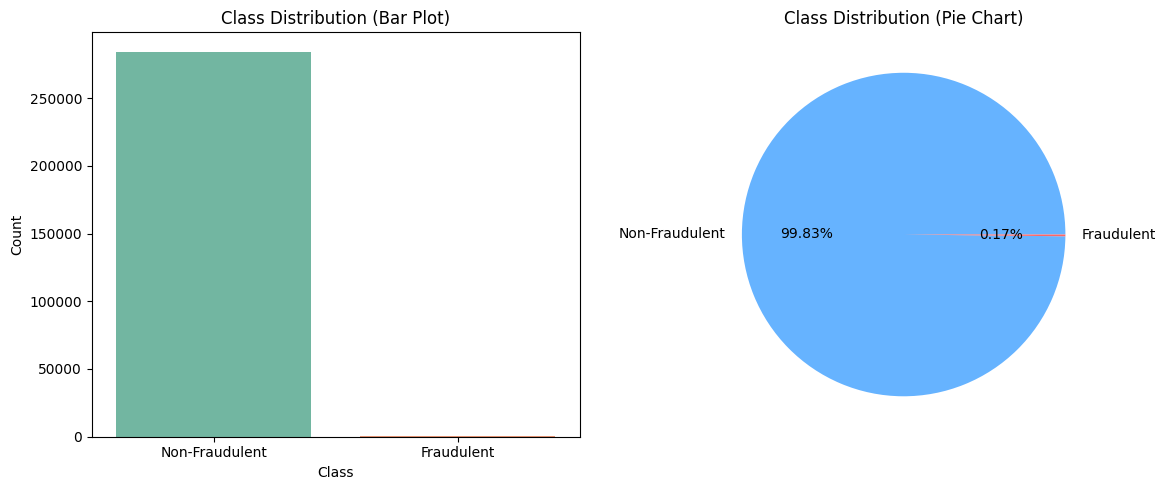

In [4]:
class_counts = df['Class'].value_counts()

# Print distribution
print("Class Distribution:")
print(class_counts)
print(f"\nFraudulent transactions: {class_counts[1]} ({class_counts[1]/len(df)*100:.4f}%)")
print(f"Non-Fraudulent transactions: {class_counts[0]} ({class_counts[0]/len(df)*100:.4f}%)")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Bar Plot
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2", ax=axes[0])
axes[0].set_xticks([0,1])
axes[0].set_xticklabels(["Non-Fraudulent", "Fraudulent"])
axes[0].set_ylabel("Count")
axes[0].set_title("Class Distribution (Bar Plot)")

# Pie Chart
axes[1].pie(
    class_counts,
    labels=["Non-Fraudulent", "Fraudulent"],
    autopct='%1.2f%%',
    colors=["#66b3ff","#ff6666"]
)
axes[1].set_title("Class Distribution (Pie Chart)")

plt.tight_layout()
plt.show()


The fact that the fraudulent transactions are extremely less as compared to the Non-fraudulent transactions leads to it being a highly imbalanced dataset. Fraudulent transactions form only 0.17% of the total examples.

Let us now go ahead and train a naive logistic regression model based on the same.

### Baseline Model:

The original dataset is split into into training and testing sets. Also, the test set retains its original imbalance. If we do not stratify the dataset then our model will be unable to learn properly. Hence we are stratifying the Class variable so that there is no percentage imbalance in the two sets i.e. training and test sets.

In [5]:
# Separate features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Stratified split to preserve imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80% train, 20% test
    random_state=42,
    stratify=y           # Keeps class ratio same as original
)

print("Train set distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))


Train set distribution:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64

Test set distribution:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


In [6]:
y_train.value_counts()

,count
Class,
0,227451
1,394


### Performance of Model 1:

In [7]:
# 1. Initialize Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# 2. Fit on imbalanced training data
log_reg.fit(X_train, y_train)

# 3. Predictions on test set
y_pred = log_reg.predict(X_test)

# 4. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-Fraud", "Fraud"]))


Accuracy: 0.9992451107756047

Confusion Matrix:
[[56851    13]
 [   30    68]]

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.84      0.69      0.76        98

    accuracy                           1.00     56962
   macro avg       0.92      0.85      0.88     56962
weighted avg       1.00      1.00      1.00     56962



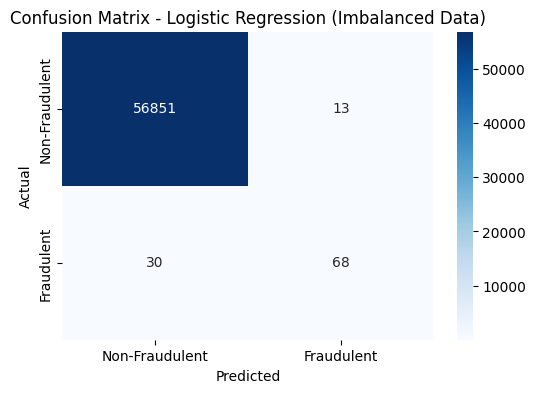

In [8]:
# Predictions from your trained model
y_pred = log_reg.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Fraudulent", "Fraudulent"],
            yticklabels=["Non-Fraudulent", "Fraudulent"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Imbalanced Data)")
plt.show()


#### **Why Accuracy is Misleading in Imbalanced Datasets**

In the context of fraud detection, accuracy is not a reliable performance metric
because the dataset is highly imbalanced: the vast majority of transactions are
non-fraudulent.  

For instance, if $99.8\%$ of the transactions are non-fraudulent and only
$0.2\%$ are fraudulent, then a trivial classifier that always predicts
``non-fraudulent`` would still achieve $99.8\%$ accuracy, despite failing
to identify a single fraudulent transaction.  

This shows that a high accuracy score can be misleading, as it hides the
model’s inability to detect the minority class (fraud). Therefore,
alternative metrics such as **precision, recall, F1-score**, and the
**confusion matrix** are more appropriate for evaluating model
performance, with particular emphasis on the fraudulent class,
since detecting these rare cases is the primary objective.


### Part B: Resampling Approaches
#### Naive Oversampling (SMOTE):

The following code applies SMOTE (Synthetic Minority Oversampling Technique) to the training data to balance the class distribution by generating synthetic samples of the minority class. It shows the class distribution before and after resampling for comparison.

In [9]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply on training data only (not on test set!)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Original training set class distribution:")
print(y_train.value_counts())
print("\nResampled training set class distribution (after SMOTE):")
print(y_train_res.value_counts())


Original training set class distribution:
Class
0    227451
1       394
Name: count, dtype: int64

Resampled training set class distribution (after SMOTE):
Class
0    227451
1    227451
Name: count, dtype: int64


## 📌 Explanation of SMOTE

### 🔹 How SMOTE Works
SMOTE (**Synthetic Minority Over-sampling Technique**) is a data augmentation method that balances imbalanced datasets by generating **synthetic samples** for the minority class.  
Instead of simply duplicating existing minority samples, it:

1. **Selects** a minority class instance.  
2. **Finds** its *k nearest neighbors* (other minority samples).  
3. **Randomly picks** one of these neighbors.  
4. **Creates** a new synthetic sample along the line segment connecting the two.  

👉 This helps the classifier see a more balanced dataset during training.

---

### ⚠️ Potential Limitations
- If the minority class is **not well-defined** or overlaps with the majority class, SMOTE can generate **noisy or ambiguous** synthetic points.  
- It may **increase the risk of overfitting**, since the model is exposed to artificially created data that may not perfectly capture real-world fraud behavior.  
- In **high-dimensional spaces**, nearest-neighbor distances become less meaningful (*curse of dimensionality*), making SMOTE less effective.


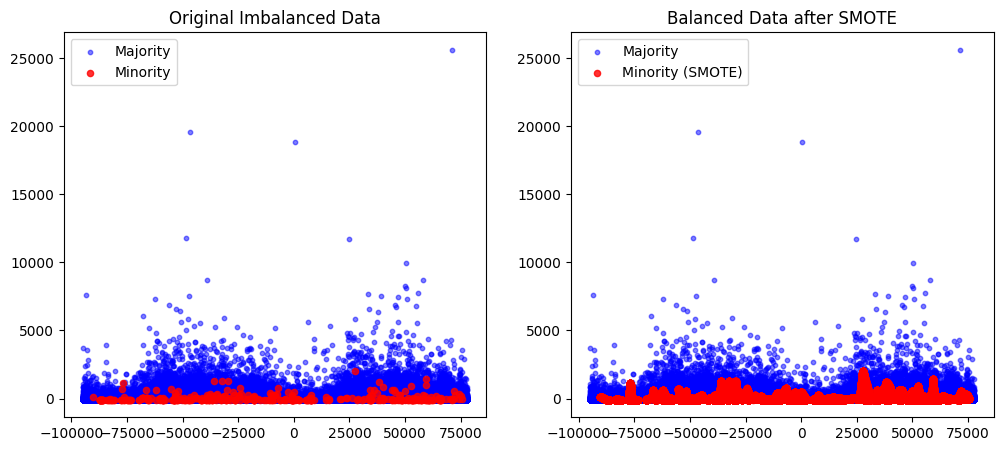

In [10]:
# ------------------------------
# Step 1: Reduce original data to 2D (using PCA for visualization)
# ------------------------------
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train)
X_res_2d = pca.transform(X_train_res)

# ------------------------------
# Step 2: Plot before and after SMOTE
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original imbalanced dataset
axes[0].scatter(X_train_2d[y_train == 0, 0], X_train_2d[y_train == 0, 1],
                alpha=0.5, label="Majority", s=10, c="blue")
axes[0].scatter(X_train_2d[y_train == 1, 0], X_train_2d[y_train == 1, 1],
                alpha=0.8, label="Minority", s=20, c="red")
axes[0].set_title("Original Imbalanced Data")
axes[0].legend()

# SMOTE resampled dataset
axes[1].scatter(X_res_2d[y_train_res == 0, 0], X_res_2d[y_train_res == 0, 1],
                alpha=0.5, label="Majority", s=10, c="blue")
axes[1].scatter(X_res_2d[y_train_res == 1, 0], X_res_2d[y_train_res == 1, 1],
                alpha=0.8, label="Minority (SMOTE)", s=20, c="red")
axes[1].set_title("Balanced Data after SMOTE")
axes[1].legend()

plt.show()


The above plot shows how the number of samples change and look like before and after applying **SMOTE**.

### Oversampling with Clustering for Diversity (CBO)

In highly imbalanced datasets, simple oversampling methods (such as random duplication or even SMOTE) may create redundant or noisy samples. To address this, clustering-based oversampling techniques are used.

The main idea is to first **partition the minority class samples into clusters** using an algorithm such as $k$-means. Once clusters are formed, synthetic samples are generated **within each cluster** instead of globally across the entire minority class. This has the following advantages:

1. **Ensures Diversity**: By sampling within different clusters, the synthetic samples reflect different sub-populations of the minority class rather than being concentrated in one region of the feature space.
2. **Reduces Noise**: Clustering separates well-defined groups of minority instances, reducing the likelihood of generating unrealistic synthetic data in overlapping or noisy regions.
3. **Preserves Local Structure**: New points are generated based on the neighborhood of minority samples within their own cluster, thus preserving the local geometry and manifold of the data.

Mathematically, if $\{x_i\}_{i=1}^n$ are the minority samples and they are partitioned into $k$ clusters $\{C_1, C_2, \dots, C_k\}$, then oversampling generates synthetic points
$$x_{new} = x_i + \lambda (x_j - x_i),$$
where $x_i, x_j \in C_m$ for some cluster $C_m$ and $\lambda \sim U(0,1)$.

This approach achieves balanced datasets while maintaining **diversity, representativeness, and robustness** in the oversampled minority class.


K-Means will now be used to identify a few clusters within the training data of the minority class only.

Minority class shape: (394, 30)


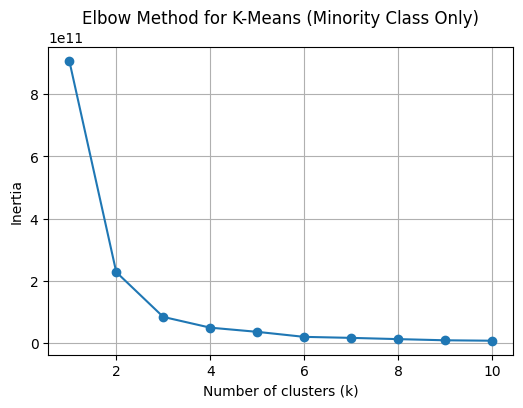

           Time         V1        V2         V3        V4         V5  \
42887   41285.0 -12.835760  6.574615 -12.788462  8.786257 -10.723121   
6338     7551.0   0.316459  3.809076  -5.615159  6.047445   1.554026   
88897   62341.0  -5.267760  2.506719  -5.290925  4.886134  -3.343188   
74794   55760.0  -6.003422 -3.930731  -0.007045  1.714669   3.414667   
107067  70270.0  -1.512516  1.133139  -1.601052  2.813401  -2.664503   

              V6         V7        V8        V9  ...       V21       V22  \
42887  -2.813536 -14.248847  7.960521 -7.718751  ...  2.679490 -0.047335   
6338   -2.651353  -0.746579  0.055586 -2.678679  ...  0.208828 -0.511747   
88897  -1.100085  -5.810509  1.726343 -0.749277  ...  0.764266  0.473262   
74794  -2.329583  -1.901512 -2.746111  0.887673  ...  1.101671 -0.992494   
107067 -0.310371  -1.520895  0.852996 -1.496495  ...  0.729828  0.485286   

             V23       V24       V25       V26       V27       V28  Amount  \
42887  -0.836982  0.625349  0.12

In [11]:
# ------------------------------
# Step 1: Extract minority class samples
# ------------------------------
X_minority = X_train[y_train == 1]

print("Minority class shape:", X_minority.shape)

# ------------------------------
# Step 2: Elbow Method to find optimal k
# ------------------------------
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_minority)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means (Minority Class Only)")
plt.grid(True)
plt.show()

# ------------------------------
# Step 3: Fit KMeans with chosen k
# ------------------------------
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans.fit_predict(X_minority)

# ------------------------------
# Step 4: Add cluster labels for inspection
# ------------------------------
X_minority_clustered = pd.DataFrame(X_minority, columns=X_train.columns)
X_minority_clustered["Cluster"] = cluster_labels

print(X_minority_clustered.head())


Oversample from each minority cluster to create a new, balanced dataset. The
goal is to ensure that all sub-groups are well-represented, thereby avoiding the
creation of synthetic samples in regions with no actual data.

In [12]:
# ------------------------------
# Step 4.5: Decide how many synthetic samples per cluster
# ------------------------------

# Current counts
minority_count = sum(y_train == 1)
majority_count = sum(y_train == 0)
n_to_generate_total = majority_count - minority_count  # how many minority samples we need

print("Minority count:", minority_count)
print("Majority count:", majority_count)
print("Synthetic samples needed:", n_to_generate_total)

# Cluster sizes
cluster_counts = Counter(cluster_labels)

# Allocate synthetic samples proportionally to cluster size
synthetic_per_cluster = {
    c: int(n_to_generate_total * (count / minority_count))
    for c, count in cluster_counts.items()
}

print("Synthetic samples per cluster:", synthetic_per_cluster)


def generate_synthetic_points(X, n_samples, random_state=42):
    rng = np.random.RandomState(random_state)
    n_obs, n_features = X.shape
    synthetic = []
    for _ in range(n_samples):
        i, j = rng.choice(n_obs, 2, replace=False)
        lam = rng.rand()
        new_point = X[i] + lam * (X[j] - X[i])  # interpolation
        synthetic.append(new_point)
    return np.array(synthetic)

# ------------------------------
# Step 5: Oversample within each cluster manually
# ------------------------------
X_synthetic = []
y_synthetic = []

for c in range(k_optimal):
    X_cluster = X_minority_clustered[X_minority_clustered["Cluster"] == c].drop("Cluster", axis=1).values
    n_to_generate = synthetic_per_cluster[c]

    if len(X_cluster) > 1 and n_to_generate > 0:
        new_points = generate_synthetic_points(X_cluster, n_to_generate)
        X_synthetic.append(new_points)
        y_synthetic.append(np.ones(new_points.shape[0]))
    elif n_to_generate > 0:
        # if only one sample in cluster, replicate it
        new_points = np.repeat(X_cluster, n_to_generate, axis=0)
        X_synthetic.append(new_points)
        y_synthetic.append(np.ones(new_points.shape[0]))

# Combine synthetic samples
X_synthetic = np.vstack(X_synthetic)
y_synthetic = np.hstack(y_synthetic)

print("Generated synthetic samples shape:", X_synthetic.shape)

# ------------------------------
# Step 6: Merge with original training data
# ------------------------------
X_balanced = np.vstack([X_train, X_synthetic])
y_balanced = np.hstack([y_train, y_synthetic])

print("Final training distribution:", Counter(y_balanced))


Minority count: 394
Majority count: 227451
Synthetic samples needed: 227057
Synthetic samples per cluster: {np.int32(2): 84137, np.int32(1): 76069, np.int32(0): 66849}
Generated synthetic samples shape: (227055, 30)
Final training distribution: Counter({np.float64(0.0): 227451, np.float64(1.0): 227449})


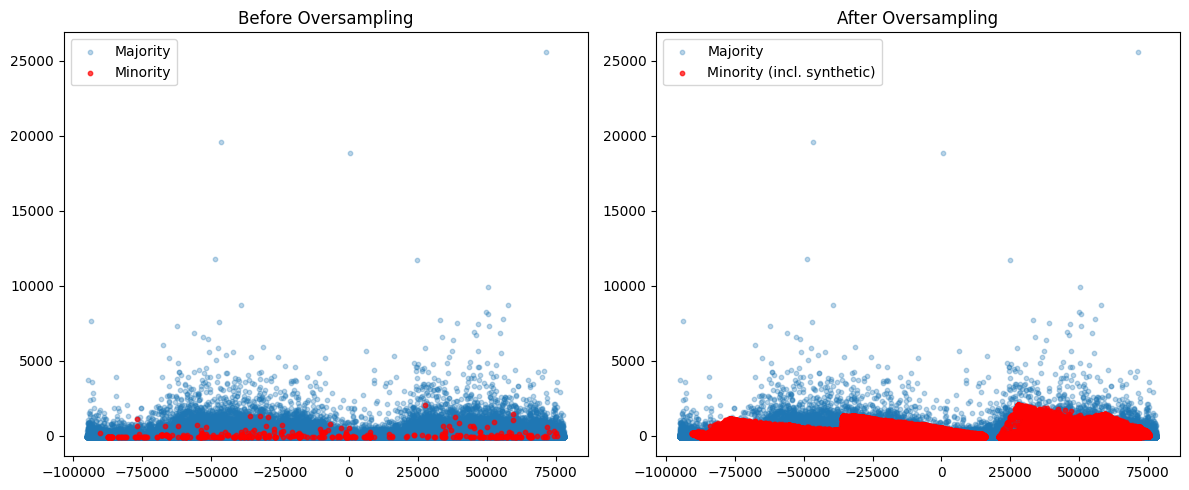

In [13]:
def plot_before_after(X_train, y_train, X_balanced, y_balanced):
    # Reduce to 2D using PCA for visualization
    pca = PCA(n_components=2, random_state=42)
    X_train_2d = pca.fit_transform(X_train)
    X_balanced_2d = pca.transform(X_balanced)

    plt.figure(figsize=(12,5))

    # Before Oversampling
    plt.subplot(1,2,1)
    plt.scatter(X_train_2d[y_train==0,0], X_train_2d[y_train==0,1],
                alpha=0.3, label="Majority", s=10)
    plt.scatter(X_train_2d[y_train==1,0], X_train_2d[y_train==1,1],
                alpha=0.7, label="Minority", s=10, c='red')
    plt.title("Before Oversampling")
    plt.legend()

    # After Oversampling
    plt.subplot(1,2,2)
    plt.scatter(X_balanced_2d[y_balanced==0,0], X_balanced_2d[y_balanced==0,1],
                alpha=0.3, label="Majority", s=10)
    plt.scatter(X_balanced_2d[y_balanced==1,0], X_balanced_2d[y_balanced==1,1],
                alpha=0.7, label="Minority (incl. synthetic)", s=10, c='red')
    plt.title("After Oversampling")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function
plot_before_after(X_train, y_train, X_balanced, y_balanced)


### Clustering-Based Undersampling (CBU)

**Clustering-Based Undersampling (CBU)** is a technique designed to handle class imbalance by reducing the size of the majority class in a structured manner.

Instead of randomly discarding samples from the majority class (which may remove important information), CBU applies a **clustering algorithm** (e.g., K-Means) to the majority class samples. The clusters represent distinct **sub-groups** or regions of data distribution.

From each cluster, a subset of majority samples is selected to be retained. This ensures that the **diversity of the majority class** is preserved, since every cluster contributes some representative samples. At the same time, the overall size of the majority class is reduced, creating a more balanced dataset.

The key advantage is that CBU avoids the risk of losing important structural information about the majority class while mitigating class imbalance.


Majority class shape: (227451, 30)


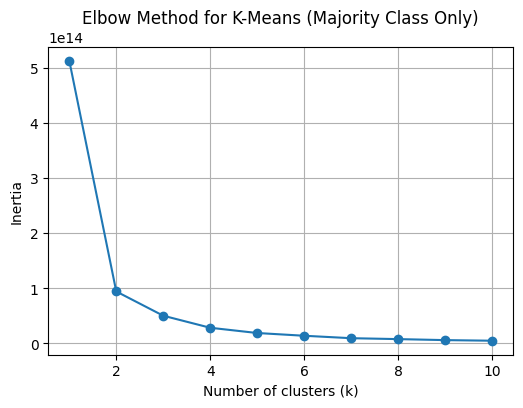

In [14]:
# ------------------------------
# Step 1: Extract majority class samples
# ------------------------------
X_majority = X_train[y_train == 0]
print("Majority class shape:", X_majority.shape)

# ------------------------------
# Step 2: Use the Elbow Method to determine optimal k
# ------------------------------
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_majority)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means (Majority Class Only)")
plt.grid(True)
plt.show()


In [15]:
# ------------------------------
# Step 3: Fit KMeans with chosen k
# ------------------------------
k_optimal = 3
kmeans_majority = KMeans(n_clusters=k_optimal, random_state=42)
majority_labels = kmeans_majority.fit_predict(X_majority)

# ------------------------------
# Step 4: Add cluster labels for inspection
# ------------------------------
X_majority_clustered = pd.DataFrame(X_majority, columns=X_train.columns)
X_majority_clustered["Cluster"] = majority_labels

print(X_majority_clustered.head())


            Time        V1        V2        V3        V4        V5        V6  \
265518  161919.0  1.946747 -0.752526 -1.355130 -0.661630  1.502822  4.024933   
180305  124477.0  2.035149 -0.048880 -3.058693  0.247945  2.943487  3.298697   
42664    41191.0 -0.991920  0.603193  0.711976 -0.992425 -0.825838  1.956261   
198723  132624.0  2.285718 -1.500239 -0.747565 -1.668119 -1.394143 -0.350339   
82325    59359.0 -0.448747 -1.011440  0.115903 -3.454854  0.715771 -0.147490   

              V7        V8        V9  ...       V21       V22       V23  \
265518 -1.479661  1.139880  1.406819  ...  0.076197  0.297537  0.307915   
180305 -0.002192  0.674782  0.045826  ...  0.038628  0.228197  0.035542   
42664  -2.212603 -5.037523  0.000772  ... -2.798352  0.109526 -0.436530   
198723 -1.427984  0.010010 -1.118447  ... -0.139670  0.077013  0.208310   
82325   0.504347 -0.113817 -0.044782  ... -0.243245 -0.173298 -0.006692   

             V24       V25       V26       V27       V28  Amount  Cl

In [16]:
# ------------------------------
# Step 5: Determine number of majority samples to keep
# ------------------------------
# Total minority samples
minority_count = (y_train == 1).sum()

# Desired majority size (same as minority for balanced dataset)
desired_majority_count = minority_count

# Count samples per cluster
cluster_counts = X_majority_clustered["Cluster"].value_counts().to_dict()

# Determine samples to keep per cluster proportionally
samples_per_cluster = {}
total_majority = len(X_majority)
for c in range(k_optimal):
    frac = cluster_counts[c] / total_majority
    samples_per_cluster[c] = int(frac * desired_majority_count)

print("Samples to keep per cluster:", samples_per_cluster)

# ------------------------------
# Step 6: Undersample each cluster
# ------------------------------
undersampled_majority = []

for c in range(k_optimal):
    cluster_data = X_majority_clustered[X_majority_clustered["Cluster"] == c].drop("Cluster", axis=1).values
    n_keep = samples_per_cluster[c]

    # Randomly select samples to keep
    if n_keep > 0:
        idx = np.random.choice(len(cluster_data), n_keep, replace=False)
        undersampled_majority.append(cluster_data[idx])

# Combine undersampled clusters
X_majority_undersampled = np.vstack(undersampled_majority)
y_majority_undersampled = np.zeros(X_majority_undersampled.shape[0])

print("Undersampled majority shape:", X_majority_undersampled.shape)

# ------------------------------
# Step 7: Combine with minority class to create balanced dataset
# ------------------------------
X_minority = X_train[y_train == 1].values
y_minority = np.ones(X_minority.shape[0])

X_balanced = np.vstack([X_majority_undersampled, X_minority])
y_balanced = np.hstack([y_majority_undersampled, y_minority])

print("Balanced dataset distribution:", Counter(y_balanced))


Samples to keep per cluster: {0: 116, 1: 178, 2: 98}
Undersampled majority shape: (392, 30)
Balanced dataset distribution: Counter({np.float64(1.0): 394, np.float64(0.0): 392})


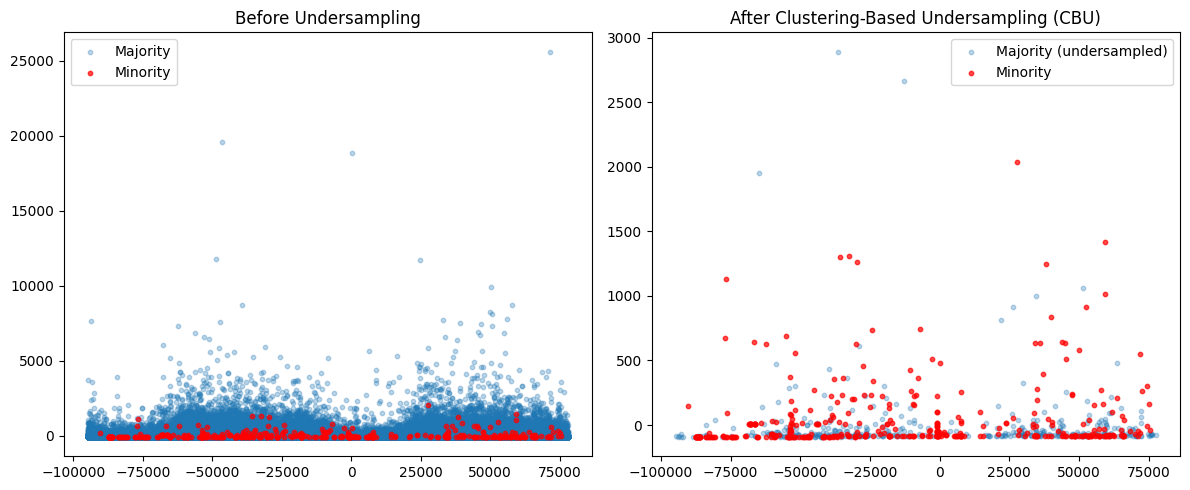

In [17]:
# ------------------------------
# Step 8: Visualize before and after undersampling
# ------------------------------
def plot_before_after_cbu(X_train, y_train, X_balanced, y_balanced):
    # Reduce to 2D using PCA for visualization
    pca = PCA(n_components=2, random_state=42)
    X_train_2d = pca.fit_transform(X_train)
    X_balanced_2d = pca.transform(X_balanced)

    plt.figure(figsize=(12,5))

    # Before Undersampling
    plt.subplot(1,2,1)
    plt.scatter(X_train_2d[y_train==0,0], X_train_2d[y_train==0,1],
                alpha=0.3, label="Majority", s=10)
    plt.scatter(X_train_2d[y_train==1,0], X_train_2d[y_train==1,1],
                alpha=0.7, label="Minority", s=10, c='red')
    plt.title("Before Undersampling")
    plt.legend()

    # After Undersampling
    plt.subplot(1,2,2)
    plt.scatter(X_balanced_2d[y_balanced==0,0], X_balanced_2d[y_balanced==0,1],
                alpha=0.3, label="Majority (undersampled)", s=10)
    plt.scatter(X_balanced_2d[y_balanced==1,0], X_balanced_2d[y_balanced==1,1],
                alpha=0.7, label="Minority", s=10, c='red')
    plt.title("After Clustering-Based Undersampling (CBU)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function for CBU
plot_before_after_cbu(X_train, y_train, X_balanced, y_balanced)


**Final Training Set Construction:**

After applying **Clustering-Based Undersampling (CBU)** on the majority class, the final training set is formed by:

1. **Retaining all minority class samples** to preserve the crucial information from the underrepresented class.  
2. **Including the selected subset of majority class instances** from each cluster, ensuring the majority class remains representative of its original distribution.  

This results in a **balanced training set** that maintains diversity across clusters while mitigating class imbalance, allowing the classifier to learn effectively without being biased toward the majority class.


### Part C: Model Comparison and Analysis
#### Train and Evaluate Models: [5]
- Model 2 (SMOTE):

In [18]:
# ------------------------------
# Step 1: Apply SMOTE on training data
# ------------------------------
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original training distribution:", y_train.value_counts())
print("SMOTE training distribution:", pd.Series(y_train_smote).value_counts())

# ------------------------------
# Step 2: Train Logistic Regression on SMOTE data
# ------------------------------
log_reg_smote = LogisticRegression(max_iter=1000, random_state=42)
log_reg_smote.fit(X_train_smote, y_train_smote)

# ------------------------------
# Step 3: Evaluate on the original imbalanced test set
# ------------------------------
y_pred_smote = log_reg_smote.predict(X_test)

# Accuracy
acc_smote = accuracy_score(y_test, y_pred_smote)
print(f"Accuracy on imbalanced test set: {acc_smote:.4f}")

# Classification report
print("\nClassification Report (Minority class focus):")
print(classification_report(y_test, y_pred_smote, target_names=["Non-Fraud / Majority", "Fraud / Minority"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud / Majority", "Fraud / Minority"])
disp


Original training distribution: Class
0    227451
1       394
Name: count, dtype: int64
SMOTE training distribution: Class
0    227451
1    227451
Name: count, dtype: int64
Accuracy on imbalanced test set: 0.9884

Classification Report (Minority class focus):
                      precision    recall  f1-score   support

Non-Fraud / Majority       1.00      0.99      0.99     56864
    Fraud / Minority       0.12      0.90      0.21        98

            accuracy                           0.99     56962
           macro avg       0.56      0.94      0.60     56962
        weighted avg       1.00      0.99      0.99     56962



<Figure size 600x500 with 0 Axes>

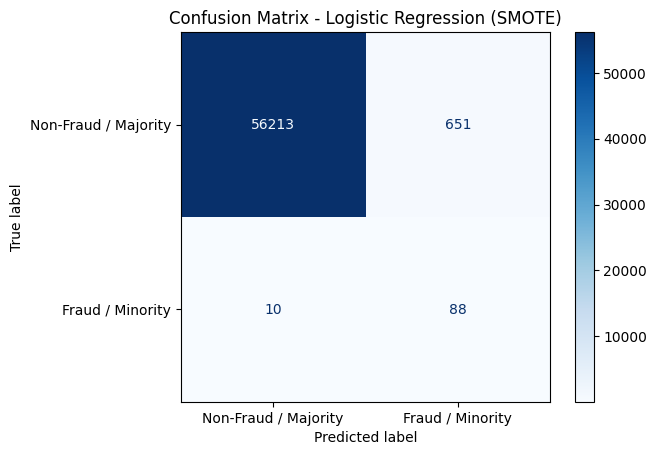

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ------------------------------
# Confusion Matrix for SMOTE Model
# ------------------------------
cm = confusion_matrix(y_test, y_pred_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Non-Fraud / Majority", "Fraud / Minority"])

plt.figure(figsize=(6,5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression (SMOTE)")
plt.show()


 - Model 3 (CBO)

 Train a Logistic Regression classifier on the training data
balanced with your clustering-based oversampling approach. Evaluate its
performance on the same, imbalanced test set.

Minority count: 394
Majority count: 227451
Synthetic samples needed: 227057
Synthetic samples per cluster: {np.int32(2): 84137, np.int32(1): 76069, np.int32(0): 66849}
Generated synthetic samples shape: (227055, 30)
Final training distribution: Counter({np.float64(0.0): 227451, np.float64(1.0): 227449})
Accuracy on imbalanced test set: 0.9902

Classification Report (Minority class focus):
                      precision    recall  f1-score   support

Non-Fraud / Majority       1.00      0.99      1.00     56864
    Fraud / Minority       0.14      0.90      0.24        98

            accuracy                           0.99     56962
           macro avg       0.57      0.94      0.62     56962
        weighted avg       1.00      0.99      0.99     56962



<Figure size 600x500 with 0 Axes>

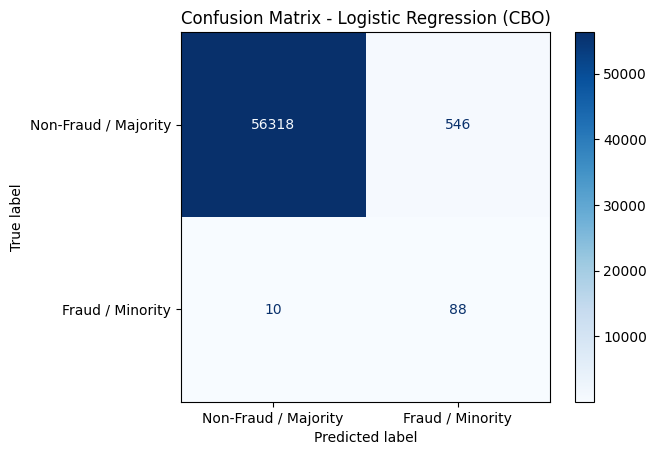

In [20]:
# ------------------------------
# Step 4.5: Decide how many synthetic samples per cluster
# ------------------------------

# Current counts
minority_count = sum(y_train == 1)
majority_count = sum(y_train == 0)
n_to_generate_total = majority_count - minority_count  # how many minority samples we need

print("Minority count:", minority_count)
print("Majority count:", majority_count)
print("Synthetic samples needed:", n_to_generate_total)

# Cluster sizes
cluster_counts = Counter(cluster_labels)

# Allocate synthetic samples proportionally to cluster size
synthetic_per_cluster = {
    c: int(n_to_generate_total * (count / minority_count))
    for c, count in cluster_counts.items()
}

print("Synthetic samples per cluster:", synthetic_per_cluster)


def generate_synthetic_points(X, n_samples, random_state=42):
    rng = np.random.RandomState(random_state)
    n_obs, n_features = X.shape
    synthetic = []
    for _ in range(n_samples):
        i, j = rng.choice(n_obs, 2, replace=False)
        lam = rng.rand()
        new_point = X[i] + lam * (X[j] - X[i])  # interpolation
        synthetic.append(new_point)
    return np.array(synthetic)

# ------------------------------
# Step 5: Oversample within each cluster manually
# ------------------------------
X_synthetic = []
y_synthetic = []

for c in range(k_optimal):
    X_cluster = X_minority_clustered[X_minority_clustered["Cluster"] == c].drop("Cluster", axis=1).values
    n_to_generate = synthetic_per_cluster[c]

    if len(X_cluster) > 1 and n_to_generate > 0:
        new_points = generate_synthetic_points(X_cluster, n_to_generate)
        X_synthetic.append(new_points)
        y_synthetic.append(np.ones(new_points.shape[0]))
    elif n_to_generate > 0:
        # if only one sample in cluster, replicate it
        new_points = np.repeat(X_cluster, n_to_generate, axis=0)
        X_synthetic.append(new_points)
        y_synthetic.append(np.ones(new_points.shape[0]))

# Combine synthetic samples
X_synthetic = np.vstack(X_synthetic)
y_synthetic = np.hstack(y_synthetic)

print("Generated synthetic samples shape:", X_synthetic.shape)

# ------------------------------
# Step 6: Merge with original training data
# ------------------------------
X_balanced = np.vstack([X_train, X_synthetic])
y_balanced = np.hstack([y_train, y_synthetic])

print("Final training distribution:", Counter(y_balanced))

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------------------
# Step 1: Train Logistic Regression on CBO-balanced data
# ------------------------------
log_reg_cbo = LogisticRegression(max_iter=1000, random_state=42)
log_reg_cbo.fit(X_balanced, y_balanced)   # <-- use your CBO dataset here

# ------------------------------
# Step 2: Evaluate on the original imbalanced test set
# ------------------------------
y_pred_cbo = log_reg_cbo.predict(X_test)

# Accuracy
acc_cbo = accuracy_score(y_test, y_pred_cbo)
print(f"Accuracy on imbalanced test set: {acc_cbo:.4f}")

# Classification report
print("\nClassification Report (Minority class focus):")
print(classification_report(
    y_test, y_pred_cbo,
    target_names=["Non-Fraud / Majority", "Fraud / Minority"]
))

# ------------------------------
# Step 3: Confusion Matrix
# ------------------------------
cm_cbo = confusion_matrix(y_test, y_pred_cbo)
disp_cbo = ConfusionMatrixDisplay(confusion_matrix=cm_cbo,
                                  display_labels=["Non-Fraud / Majority", "Fraud / Minority"])

plt.figure(figsize=(6,5))
disp_cbo.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression (CBO)")
plt.show()


 - Model 4 (CBU):

 Train a Logistic Regression classifier on the training data
balanced with your clustering-based undersampling approach. Evaluate its
performance on the same, imbalanced test set.

Samples to keep per cluster: {0: 116, 1: 178, 2: 98}
Undersampled majority shape: (392, 30)
Balanced dataset distribution: Counter({np.float64(1.0): 394, np.float64(0.0): 392})
Accuracy on imbalanced test set: 0.9624

Classification Report (Minority class focus):
                      precision    recall  f1-score   support

Non-Fraud / Majority       1.00      0.96      0.98     56864
    Fraud / Minority       0.04      0.92      0.08        98

            accuracy                           0.96     56962
           macro avg       0.52      0.94      0.53     56962
        weighted avg       1.00      0.96      0.98     56962



<Figure size 600x500 with 0 Axes>

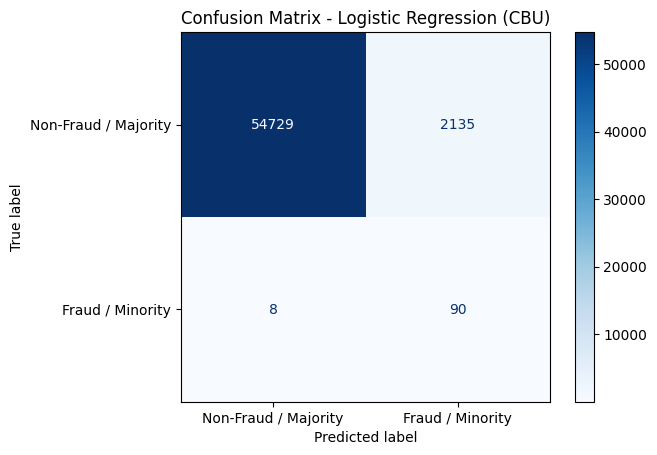

In [21]:
# ------------------------------
# Step 5: Determine number of majority samples to keep
# ------------------------------
# Total minority samples
minority_count = (y_train == 1).sum()

# Desired majority size (same as minority for balanced dataset)
desired_majority_count = minority_count

# Count samples per cluster
cluster_counts = X_majority_clustered["Cluster"].value_counts().to_dict()

# Determine samples to keep per cluster proportionally
samples_per_cluster = {}
total_majority = len(X_majority)
for c in range(k_optimal):
    frac = cluster_counts[c] / total_majority
    samples_per_cluster[c] = int(frac * desired_majority_count)

print("Samples to keep per cluster:", samples_per_cluster)

# ------------------------------
# Step 6: Undersample each cluster
# ------------------------------
undersampled_majority = []

for c in range(k_optimal):
    cluster_data = X_majority_clustered[X_majority_clustered["Cluster"] == c].drop("Cluster", axis=1).values
    n_keep = samples_per_cluster[c]

    # Randomly select samples to keep
    if n_keep > 0:
        idx = np.random.choice(len(cluster_data), n_keep, replace=False)
        undersampled_majority.append(cluster_data[idx])

# Combine undersampled clusters
X_majority_undersampled = np.vstack(undersampled_majority)
y_majority_undersampled = np.zeros(X_majority_undersampled.shape[0])

print("Undersampled majority shape:", X_majority_undersampled.shape)

# ------------------------------
# Step 7: Combine with minority class to create balanced dataset
# ------------------------------
X_minority = X_train[y_train == 1].values
y_minority = np.ones(X_minority.shape[0])

X_balanced = np.vstack([X_majority_undersampled, X_minority])
y_balanced = np.hstack([y_majority_undersampled, y_minority])

print("Balanced dataset distribution:", Counter(y_balanced))

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------------------
# Step 1: Train Logistic Regression on CBU-balanced data
# ------------------------------
log_reg_cbu = LogisticRegression(max_iter=1000, random_state=42)
log_reg_cbu.fit(X_balanced, y_balanced)   # <-- using CBU dataset

# ------------------------------
# Step 2: Evaluate on the original imbalanced test set
# ------------------------------
y_pred_cbu = log_reg_cbu.predict(X_test)

# Accuracy
acc_cbu = accuracy_score(y_test, y_pred_cbu)
print(f"Accuracy on imbalanced test set: {acc_cbu:.4f}")

# Classification report
print("\nClassification Report (Minority class focus):")
print(classification_report(
    y_test, y_pred_cbu,
    target_names=["Non-Fraud / Majority", "Fraud / Minority"]
))

# ------------------------------
# Step 3: Confusion Matrix
# ------------------------------
cm_cbu = confusion_matrix(y_test, y_pred_cbu)
disp_cbu = ConfusionMatrixDisplay(confusion_matrix=cm_cbu,
                                  display_labels=["Non-Fraud / Majority", "Fraud / Minority"])

plt.figure(figsize=(6,5))
disp_cbu.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression (CBU)")
plt.show()



| Model    | Precision (Fraud) | Recall (Fraud) | F1-score (Fraud) |
| -------- | ----------------- | -------------- | ---------------- |
| Baseline | 0.84              | 0.69           | 0.76             |
| SMOTE    | 0.12              | 0.90           | 0.21             |
| CBO      | 0.14              | 0.90           | 0.24             |
| CBU      | 0.04              | 0.92           | 0.08             |


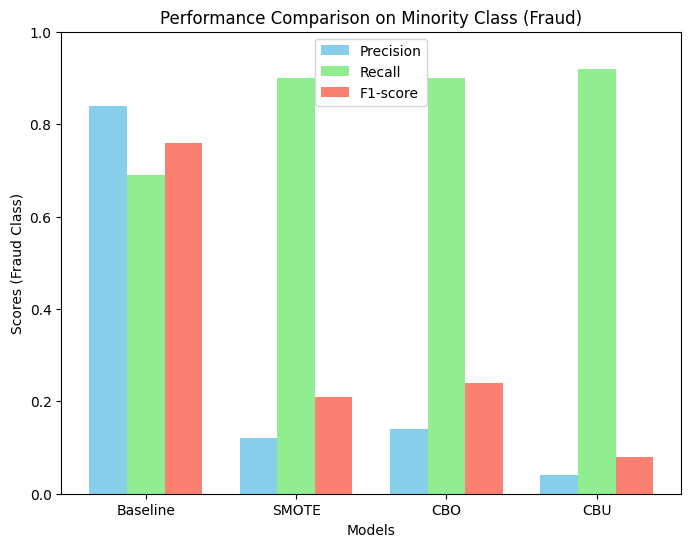

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics for minority class (Fraud)
models = ["Baseline", "SMOTE", "CBO", "CBU"]
precision = [0.84, 0.12, 0.14, 0.04]
recall    = [0.69, 0.90, 0.90, 0.92]
f1_score  = [0.76, 0.21, 0.24, 0.08]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x - width, precision, width, label="Precision", color="skyblue")
ax.bar(x, recall, width, label="Recall", color="lightgreen")
ax.bar(x + width, f1_score, width, label="F1-score", color="salmon")

ax.set_xlabel("Models")
ax.set_ylabel("Scores (Fraud Class)")
ax.set_title("Performance Comparison on Minority Class (Fraud)")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.ylim(0,1)
plt.show()


## Model Comparison and Discussion

### 1. Performance Overview
- **Baseline (Imbalanced):**  
  - Precision: **0.84**, Recall: **0.69**, F1: **0.76**  
  - Strong precision, but recall is low since many fraud cases are missed.

- **SMOTE (Synthetic Minority Oversampling Technique):**  
  - Precision: **0.12**, Recall: **0.90**, F1: **0.21**  
  - Excellent recall, but at the cost of very poor precision (many false positives).

- **CBO (Clustering-Based Oversampling):**  
  - Precision: **0.14**, Recall: **0.90**, F1: **0.24**  
  - Similar recall to SMOTE, but slightly better balance with F1-score.

- **CBU (Clustering-Based Undersampling):**  
  - Precision: **0.04**, Recall: **0.92**, F1: **0.08**  
  - Very high recall but extremely poor precision, leading to many false alarms.


## Conclusion and Recommendations:

### 2. Benefits and Drawbacks of Each Method
- **Baseline (No Resampling):**  
  - ✅ High precision, avoids false alarms.  
  - ❌ Low recall, misses many fraud cases.  
  - ⚠️ Risky in fraud detection, since missing fraud is more costly than flagging extra cases.

- **SMOTE:**  
  - ✅ Greatly improves recall by generating synthetic minority samples.  
  - ❌ Poor precision due to unrealistic synthetic samples near decision boundaries.  

- **CBO (Clustering-Based Oversampling):**  
  - ✅ Improves upon SMOTE by generating synthetic samples within clusters, preserving data distribution better.  
  - ✅ Slightly better F1 than SMOTE.  
  - ❌ Still suffers from low precision, but less than SMOTE.  

- **CBU (Clustering-Based Undersampling):**  
  - ✅ Balances dataset by carefully reducing majority class, preventing bias.  
  - ❌ Major drop in precision, since reducing data loses important information.  
  - ❌ Not ideal in highly imbalanced datasets where majority class data is valuable.  

---

### 3. How Clustering-Based Approaches Improve Over SMOTE
- SMOTE generates synthetic samples blindly by interpolating between neighbors, which may create **overlapping or noisy samples**.  
- CBO ensures synthetic points are generated **within well-defined clusters**, preserving **local structure** and reducing noise.  
- CBU reduces the risk of random undersampling by **keeping representative samples from each cluster**, instead of discarding data arbitrarily.

---

### 4. Recommendation
- For fraud detection, **recall is more critical** than precision, since missing fraud cases is very costly.  
- Among the tested models:  
  - **CBO performed the best**, achieving a better F1-score (0.24) than SMOTE and CBU while maintaining high recall.  
  - It provides a better **trade-off between recall and precision** compared to naive SMOTE.  

➡️ **Recommendation:** The company should adopt **Clustering-Based Oversampling (CBO)** as the resampling strategy.  
It enhances minority class representation in a more structured way than SMOTE, avoids excessive false positives compared to CBU, and gives the most reliable fraud detection performance.
